# 08 - Feature Engineering

## Purpose

This notebook finalizes a stable and interpretable feature set optimized for
**Logistic Regression**, our chosen model for its interpretability and proven
performance on this dataset.

It performs two operations:
1. **Feature selection** — keep 11 informative raw features, drop the rest
2. **Feature engineering** — create 14 new features that compensate for LR limitations

## Feature Decisions (from previous notebooks)

### Features to DROP

| Category | Features | Reason |
|----------|----------|--------|
| Demographics | `gender`, `Partner` | Low signal, not actionable |
| Telephony | `PhoneService`, `MultipleLines` | Redundant, low discriminative power |
| Secondary Services | `OnlineBackup`, `DeviceProtection`, `StreamingTV`, `StreamingMovies` | Used indirectly via service count aggregation |

### Features to KEEP (11 raw features)

| Type | Features |
|------|----------|
| Numerical | `tenure`, `MonthlyCharges`, `TotalCharges` |
| Categorical | `Contract`, `InternetService`, `OnlineSecurity`, `TechSupport`, `PaymentMethod` |
| Binary / Ordinal | `SeniorCitizen`, `Dependents`, `PaperlessBilling` |

### 14 Engineered Features for Logistic Regression

A Logistic Regression can only learn **linear combinations** (a*x1 + b*x2 + ...).  
It cannot learn ratios, products, non-linear effects, or interactions on its own.  
We create these features manually so the LR can exploit them.

| Category | Features | Why LR needs this |
|----------|----------|---------|
| **Ratios (5)** | `avg_monthly_spend`, `charge_tenure_ratio`, `charge_deviation`, `expected_lifetime_value`, `overpay_indicator` | LR cannot divide or multiply variables |
| **Binning (1)** | `tenure_group` | LR assumes linear effect — but churn vs tenure is non-linear |
| **Aggregation (2)** | `num_support_services`, `num_streaming_services` | LR sees 4 separate dummies — aggregation gives one clean signal |
| **Interactions (4)** | `is_mtm_fiber`, `is_mtm_no_support`, `is_echeck_mtm`, `tenure_x_contract` | LR cannot cross two categorical variables |
| **Binary (2)** | `is_auto_pay`, `has_internet` | Simplifies multi-category into one coefficient |

---
## 1. Setup & Imports

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.style.use('seaborn-v0_8-whitegrid')

print("Setup complete.")

Setup complete.


---
## 2. Configuration

In [68]:
# Paths
import os

PROJECT_ROOT = Path.cwd().parent
DATA_PROCESSED_PATH = PROJECT_ROOT / "data" / "processed"
MODELS_PATH = PROJECT_ROOT / "models"

# Create directories if they don't exist
DATA_PROCESSED_PATH.mkdir(parents=True, exist_ok=True)
MODELS_PATH.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_PROCESSED_PATH exists:", DATA_PROCESSED_PATH.exists())

PROJECT_ROOT: /Users/omarpiro/churn_ml_decision
DATA_PROCESSED_PATH exists: True


In [69]:
# Feature decisions

# --- Features to DROP ---
FEATURES_TO_DROP = [
    # Demographics (low signal)
    "gender",
    "Partner",
    # Telephony (redundant)
    "PhoneService",
    "MultipleLines",
    # Secondary services (used indirectly via service count aggregation)
    "OnlineBackup",
    "DeviceProtection",
    "StreamingTV",
    "StreamingMovies",
]

# --- Raw features to KEEP ---
NUMERICAL_FEATURES = ["tenure", "MonthlyCharges", "TotalCharges"]

CATEGORICAL_FEATURES = [
    "Contract",
    "InternetService",
    "OnlineSecurity",
    "TechSupport",
    "PaymentMethod",
]

BINARY_FEATURES = ["SeniorCitizen", "Dependents", "PaperlessBilling"]

# --- Engineered feature names (created in section 5) ---
ENGINEERED_FEATURES = [
    'avg_monthly_spend', 'charge_tenure_ratio', 'charge_deviation',
    'expected_lifetime_value', 'overpay_indicator',
    'tenure_group',
    'num_support_services', 'num_streaming_services',
    'is_mtm_fiber', 'is_mtm_no_support', 'is_echeck_mtm', 'tenure_x_contract',
    'is_auto_pay', 'has_internet'
]

# Target and ID
TARGET = "Churn"
ID_COLUMN = "customerID"

print(f"Features to drop: {len(FEATURES_TO_DROP)}")
print(f"Numerical features to keep: {len(NUMERICAL_FEATURES)}")
print(f"Categorical features to keep: {len(CATEGORICAL_FEATURES)}")
print(f"Binary features to keep: {len(BINARY_FEATURES)}")
print(f"Engineered features to create: {len(ENGINEERED_FEATURES)}")
print(f"\nTotal raw features: {len(NUMERICAL_FEATURES) + len(CATEGORICAL_FEATURES) + len(BINARY_FEATURES)}")
print(f"Total after engineering: {len(NUMERICAL_FEATURES) + len(CATEGORICAL_FEATURES) + len(BINARY_FEATURES) + len(ENGINEERED_FEATURES)}")

Features to drop: 8
Numerical features to keep: 3
Categorical features to keep: 5
Binary features to keep: 3
Engineered features to create: 14

Total raw features: 11
Total after engineering: 25


---
## 3. Data Loading

In [70]:
# Load split datasets
X_train = pd.read_csv(DATA_PROCESSED_PATH / "X_train.csv")
X_val = pd.read_csv(DATA_PROCESSED_PATH / "X_val.csv")
X_test = pd.read_csv(DATA_PROCESSED_PATH / "X_test.csv")

y_train = pd.read_csv(DATA_PROCESSED_PATH / "y_train.csv").squeeze()
y_val = pd.read_csv(DATA_PROCESSED_PATH / "y_val.csv").squeeze()
y_test = pd.read_csv(DATA_PROCESSED_PATH / "y_test.csv").squeeze()

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nAvailable features ({X_train.shape[1]}): {X_train.columns.tolist()}")

X_train shape: (4225, 19)
X_val shape: (1409, 19)
X_test shape: (1409, 19)

Available features (19): ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


In [71]:
# Verify target encoding (should be 0/1)
print(f"Target unique values: {y_train.unique()}")
print(f"Target distribution (train):\n{y_train.value_counts(normalize=True)}")

Target unique values: [0 1]
Target distribution (train):
Churn
0    0.734675
1    0.265325
Name: proportion, dtype: float64


---
## 4. Feature Selection

In [72]:
def apply_feature_selection(df, features_to_drop, features_to_keep):
    """
    Apply feature selection by dropping unwanted features and keeping only selected ones.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe
    features_to_drop : list
        Features to explicitly drop
    features_to_keep : list
        Features to explicitly keep
    
    Returns
    -------
    pd.DataFrame
        Dataframe with selected features only
    """
    # Get columns that exist in the dataframe
    cols_to_drop = [col for col in features_to_drop if col in df.columns]
    cols_to_keep = [col for col in features_to_keep if col in df.columns]
    
    # Log dropped columns
    if cols_to_drop:
        print(f"Dropping {len(cols_to_drop)} features: {cols_to_drop}")
    
    # Keep only selected features
    df_selected = df[cols_to_keep].copy()
    
    return df_selected

In [73]:
# Define final raw feature list (11 features)
FEATURES_TO_KEEP = NUMERICAL_FEATURES + CATEGORICAL_FEATURES + BINARY_FEATURES

print(f"Final features to keep ({len(FEATURES_TO_KEEP)}):\n")
print(f"  Numerical:   {NUMERICAL_FEATURES}")
print(f"  Categorical: {CATEGORICAL_FEATURES}")
print(f"  Binary:      {BINARY_FEATURES}")

Final features to keep (11):

  Numerical:   ['tenure', 'MonthlyCharges', 'TotalCharges']
  Categorical: ['Contract', 'InternetService', 'OnlineSecurity', 'TechSupport', 'PaymentMethod']
  Binary:      ['SeniorCitizen', 'Dependents', 'PaperlessBilling']


In [74]:
# Apply feature selection to all datasets
print("Applying feature selection to training set:")
X_train_selected = apply_feature_selection(X_train, FEATURES_TO_DROP, FEATURES_TO_KEEP)

print("\nApplying feature selection to validation set:")
X_val_selected = apply_feature_selection(X_val, FEATURES_TO_DROP, FEATURES_TO_KEEP)

print("\nApplying feature selection to test set:")
X_test_selected = apply_feature_selection(X_test, FEATURES_TO_DROP, FEATURES_TO_KEEP)

Applying feature selection to training set:
Dropping 8 features: ['gender', 'Partner', 'PhoneService', 'MultipleLines', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies']

Applying feature selection to validation set:
Dropping 8 features: ['gender', 'Partner', 'PhoneService', 'MultipleLines', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies']

Applying feature selection to test set:
Dropping 8 features: ['gender', 'Partner', 'PhoneService', 'MultipleLines', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies']


In [75]:
# Verify resulting shapes
print("\nResulting shapes after feature selection:")
print(f"  X_train_selected: {X_train_selected.shape}")
print(f"  X_val_selected: {X_val_selected.shape}")
print(f"  X_test_selected: {X_test_selected.shape}")

print(f"\nSelected features: {X_train_selected.columns.tolist()}")


Resulting shapes after feature selection:
  X_train_selected: (4225, 11)
  X_val_selected: (1409, 11)
  X_test_selected: (1409, 11)

Selected features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'Contract', 'InternetService', 'OnlineSecurity', 'TechSupport', 'PaymentMethod', 'SeniorCitizen', 'Dependents', 'PaperlessBilling']


---
## 5. Feature Engineering

The LR can only learn linear combinations: `a*x1 + b*x2 + c*x3 + ...`

It **cannot** learn:
- Ratios (A / B)
- Products (A * B)
- Non-linear effects (churn drops steeply for tenure 0-6, then flattens)
- Interactions (Month-to-month AND Fiber optic is worse than the sum)

We create these features manually so the LR can use them as linear inputs.

**Data leakage prevention:** all statistics (medians) are computed on training set only.

In [1]:
def engineer_features(df, train_medians=None, fit=False):
    """
    Create 14 engineered features optimized for Logistic Regression.
    
    Parameters
    ----------
    df : pd.DataFrame
        Selected raw features.
    train_medians : dict or None
        Median MonthlyCharges per InternetService group (from training set).
        Required when fit=False.
    fit : bool
        If True, compute train_medians from df and return them.
    
    Returns
    -------
    df_eng : pd.DataFrame
        DataFrame with 14 new features added.
    train_medians : dict
        (only returned if fit=True)
    """
    df_eng = df.copy()
    
    # Ensure TotalCharges is numeric
    df_eng['TotalCharges'] = pd.to_numeric(df_eng['TotalCharges'], errors='coerce').fillna(0)
    
    # Safe tenure (avoid division by zero)
    safe_tenure = df_eng['tenure'].clip(lower=1)
    
    # =========================================================
    # 5.1  Ratios — LR cannot divide or multiply variables
    # =========================================================
    
    # Average monthly spend (breaks tenure/TotalCharges correlation of 0.83)
    df_eng['avg_monthly_spend'] = df_eng['TotalCharges'] / safe_tenure
    
    # Charge-to-tenure ratio (high price + low tenure = high risk)
    df_eng['charge_tenure_ratio'] = df_eng['MonthlyCharges'] / safe_tenure
    
    # Charge deviation (positive = paying more now than average history)
    df_eng['charge_deviation'] = df_eng['MonthlyCharges'] - df_eng['avg_monthly_spend']
    
    # Expected lifetime value (proxy for customer value)
    df_eng['expected_lifetime_value'] = df_eng['MonthlyCharges'] * df_eng['tenure']
    
    # Overpay indicator (vs peer group median — median from train only)
    if fit:
        train_medians = df_eng.groupby('InternetService')['MonthlyCharges'].median().to_dict()
    
    df_eng['overpay_indicator'] = (
        df_eng['MonthlyCharges'] 
        - df_eng['InternetService'].map(train_medians)
    )
    
    # =========================================================
    # 5.2  Tenure Binning 
    # =========================================================
    bins = [0, 6, 12, 24, 48, 72]
    labels = [0, 1, 2, 3, 4]  # new, early, developing, established, loyal
    df_eng['tenure_group'] = pd.cut(
        df_eng['tenure'], bins=bins, labels=labels, include_lowest=True
    ).astype(float)
    
    # =========================================================
    # 5.3  Service Count Aggregation 
    # =========================================================
    support_cols = ['OnlineSecurity', 'TechSupport', 'OnlineBackup', 'DeviceProtection']
    streaming_cols = ['StreamingTV', 'StreamingMovies']
    
    # Some service columns may have been dropped — handle gracefully
    df_eng['num_support_services'] = sum(
        (df_eng[col] == 'Yes').astype(int) if col in df_eng.columns
        else pd.Series(0, index=df_eng.index)
        for col in support_cols
    )
    df_eng['num_streaming_services'] = sum(
        (df_eng[col] == 'Yes').astype(int) if col in df_eng.columns
        else pd.Series(0, index=df_eng.index)
        for col in streaming_cols
    )
    
    # =========================================================
    # 5.4  Interactions
    # =========================================================
    
    # Month-to-month + Fiber optic (~50% churn segment)
    df_eng['is_mtm_fiber'] = (
        (df_eng['Contract'] == 'Month-to-month') & 
        (df_eng['InternetService'] == 'Fiber optic')
    ).astype(int)
    
    # Month-to-month + zero support services
    df_eng['is_mtm_no_support'] = (
        (df_eng['Contract'] == 'Month-to-month') & 
        (df_eng['num_support_services'] == 0)
    ).astype(int)
    
    # Electronic check + Month-to-month (double disengagement)
    df_eng['is_echeck_mtm'] = (
        (df_eng['PaymentMethod'] == 'Electronic check') & 
        (df_eng['Contract'] == 'Month-to-month')
    ).astype(int)
    
    # Tenure x Contract ordinal (engagement * loyalty interaction)
    contract_ord = df_eng['Contract'].map({
        'Month-to-month': 0, 'One year': 1, 'Two year': 2
    })
    df_eng['tenure_x_contract'] = df_eng['tenure'] * contract_ord
    
    # =========================================================
    # 5.5  Binary Simplification 
    # =========================================================
    
    # Automatic payment (bank transfer or credit card)
    df_eng['is_auto_pay'] = df_eng['PaymentMethod'].isin([
        'Bank transfer (automatic)', 'Credit card (automatic)'
    ]).astype(int)
    
    # Has internet service
    df_eng['has_internet'] = (df_eng['InternetService'] != 'No').astype(int)
    
    if fit:
        return df_eng, train_medians
    return df_eng

In [77]:
# Apply feature engineering: fit on train, transform val and test
X_train_eng, train_medians = engineer_features(X_train_selected, fit=True)
X_val_eng = engineer_features(X_val_selected, train_medians=train_medians)
X_test_eng = engineer_features(X_test_selected, train_medians=train_medians)

print(f"Before engineering: {X_train_selected.shape[1]} features")
print(f"After engineering:  {X_train_eng.shape[1]} features")
print(f"New features added: {X_train_eng.shape[1] - X_train_selected.shape[1]}")
print(f"\nTrain medians (for overpay_indicator): {train_medians}")

Before engineering: 11 features
After engineering:  25 features
New features added: 14

Train medians (for overpay_indicator): {'DSL': 56.25, 'Fiber optic': 93.15, 'No': 20.15}


In [78]:
# Inspect the 14 engineered features
print(f"Engineered features ({len(ENGINEERED_FEATURES)}):\n")
for feat in ENGINEERED_FEATURES:
    series = X_train_eng[feat]
    print(f"  {feat:30s}  dtype={str(series.dtype):8s}  "
          f"min={series.min():8.2f}  max={series.max():8.2f}  "
          f"mean={series.mean():8.2f}  nulls={series.isna().sum()}")

Engineered features (14):

  avg_monthly_spend               dtype=float64   min=    0.00  max=  121.40  mean=   64.85  nulls=0
  charge_tenure_ratio             dtype=float64   min=    0.27  max=  101.45  mean=    8.70  nulls=0
  charge_deviation                dtype=float64   min=  -17.12  max=   73.35  mean=    0.04  nulls=0
  expected_lifetime_value         dtype=float64   min=    0.00  max= 8550.00  mean= 2294.41  nulls=0
  overpay_indicator               dtype=float64   min=  -32.80  max=   37.00  mean=    0.35  nulls=0
  tenure_group                    dtype=float64   min=    0.00  max=    4.00  mean=    2.34  nulls=0
  num_support_services            dtype=int64     min=    0.00  max=    2.00  mean=    0.59  nulls=0
  num_streaming_services          dtype=int64     min=    0.00  max=    0.00  mean=    0.00  nulls=0
  is_mtm_fiber                    dtype=int64     min=    0.00  max=    1.00  mean=    0.30  nulls=0
  is_mtm_no_support               dtype=int64     min=    0.00  

In [79]:
# Sample of engineered features
print("Sample (first 5 rows):")
X_train_eng[ENGINEERED_FEATURES].head()

Sample (first 5 rows):


,avg_monthly_spend,charge_tenure_ratio,charge_deviation,expected_lifetime_value,overpay_indicator,tenure_group,num_support_services,num_streaming_services,is_mtm_fiber,is_mtm_no_support,is_echeck_mtm,tenure_x_contract,is_auto_pay,has_internet
0,60.870455,0.926515,0.279545,4035.90,4.90,4.0,1,0,0,0,0,132,1,1
1,83.987692,1.305385,0.862308,5515.25,28.60,4.0,2,0,0,0,0,130,1,1
2,18.811111,0.282639,1.538889,1465.20,0.20,4.0,0,0,0,0,0,144,0,0
3,72.841912,1.072794,0.108088,4960.60,16.70,4.0,1,0,0,0,0,136,1,1
4,36.020833,2.958333,-0.520833,426.00,-20.75,1.0,1,0,0,0,0,0,0,1


---
## 6. Feature Analysis

Validate that the engineered features carry signal for churn prediction.

In [80]:
# Correlation with churn target
train_with_target = X_train_eng[ENGINEERED_FEATURES].copy()
train_with_target['Churn'] = y_train.values

correlations = (
    train_with_target
    .corr()['Churn']
    .drop('Churn')
    .sort_values(key=abs, ascending=False)
)

print("Correlation of engineered features with Churn:")
print("=" * 55)
for feat, corr in correlations.items():
    # Check if correlation value is NaN before trying to convert to int
    if pd.notna(corr):  # Only process if correlation is not NaN
        bar = '#' * int(abs(corr) * 40)
        sign = '+' if corr > 0 else '-'
        print(f"  {feat:30s} {corr:+.4f}  {sign}{bar}")
    else:
        # Handle NaN values by showing them without a bar
        print(f"  {feat:30s} NaN")

Correlation of engineered features with Churn:
  is_mtm_fiber                   +0.4240  +################
  is_mtm_no_support              +0.3790  +###############
  is_echeck_mtm                  +0.3774  +###############
  charge_tenure_ratio            +0.3743  +##############
  tenure_group                   -0.3562  -##############
  tenure_x_contract              -0.3431  -#############
  overpay_indicator              -0.2429  -#########
  has_internet                   +0.2313  +#########
  is_auto_pay                    -0.2186  -########
  num_support_services           -0.2059  -########
  avg_monthly_spend              +0.1977  +#######
  expected_lifetime_value        -0.1918  -#######
  charge_deviation               -0.0127  -
  num_streaming_services         NaN


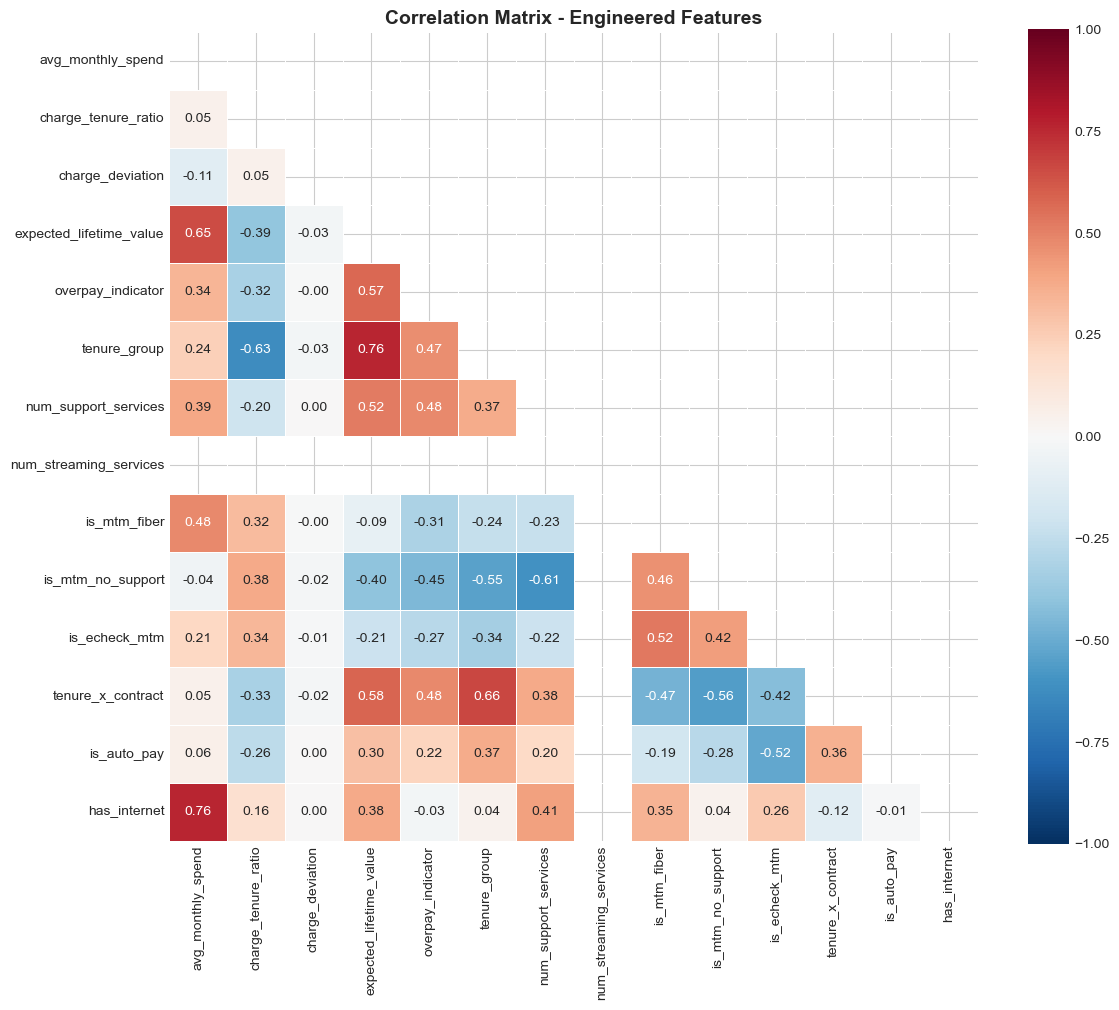

In [81]:
# Correlation heatmap between engineered features
fig, ax = plt.subplots(figsize=(12, 10))

corr_matrix = X_train_eng[ENGINEERED_FEATURES].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt='.2f',
    cmap='RdBu_r', center=0, vmin=-1, vmax=1,
    square=True, linewidths=0.5, ax=ax
)
ax.set_title('Correlation Matrix - Engineered Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

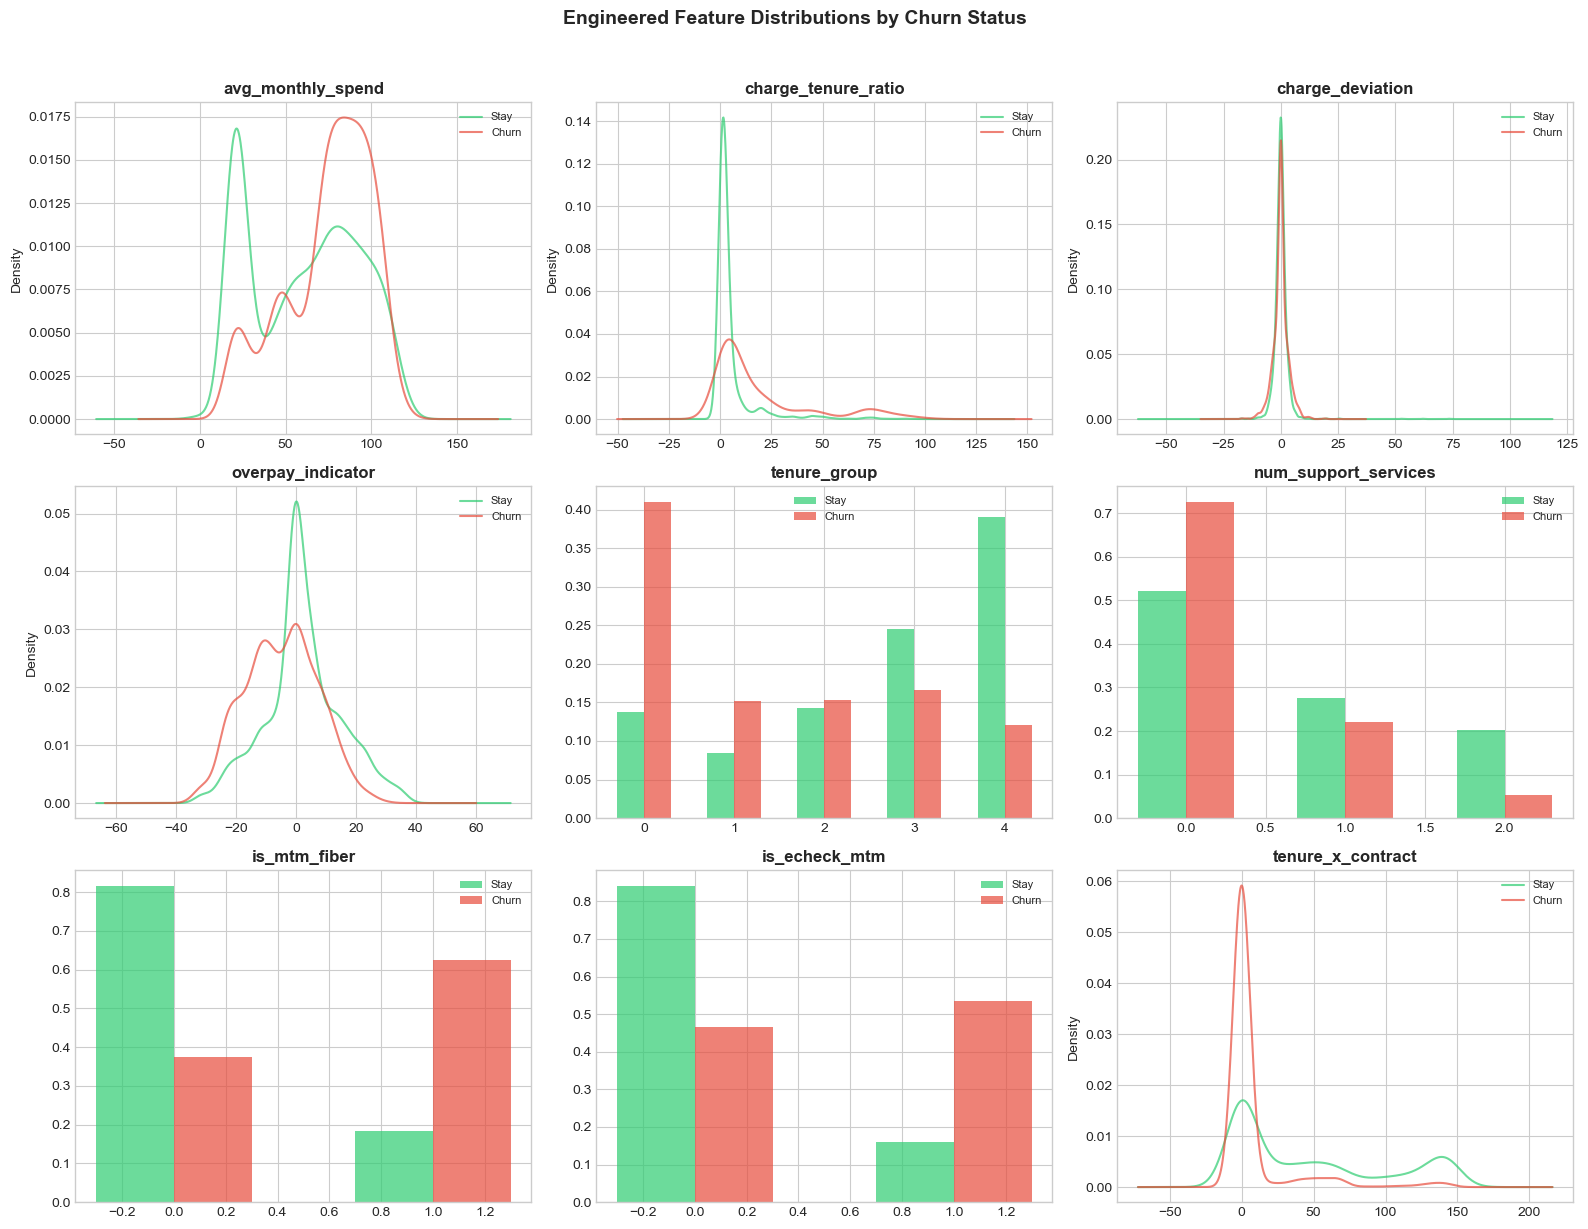

In [82]:
# Distribution of key features by churn status
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

plot_features = [
    'avg_monthly_spend', 'charge_tenure_ratio', 'charge_deviation',
    'overpay_indicator', 'tenure_group', 'num_support_services',
    'is_mtm_fiber', 'is_echeck_mtm', 'tenure_x_contract'
]

for ax, feat in zip(axes.flatten(), plot_features):
    for label, color in [(0, '#2ecc71'), (1, '#e74c3c')]:
        subset = X_train_eng[y_train == label][feat]
        if X_train_eng[feat].nunique() <= 6:
            counts = subset.value_counts(normalize=True).sort_index()
            ax.bar(
                counts.index + (0.15 if label == 1 else -0.15),
                counts.values, width=0.3, alpha=0.7, color=color,
                label=f"{'Churn' if label == 1 else 'Stay'}"
            )
        else:
            subset.plot.kde(ax=ax, color=color, alpha=0.7,
                          label=f"{'Churn' if label == 1 else 'Stay'}")
    ax.set_title(feat, fontweight='bold')
    ax.legend(fontsize=8)

plt.suptitle('Engineered Feature Distributions by Churn Status',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [83]:
# Churn rate by binary interaction features
interaction_features = ['is_mtm_fiber', 'is_mtm_no_support', 'is_echeck_mtm', 'is_auto_pay', 'has_internet']

print("Churn rate by binary features:")
print("=" * 60)
for feat in interaction_features:
    churn_rates = X_train_eng.groupby(feat).apply(
        lambda x: y_train.loc[x.index].mean()
    )
    counts = X_train_eng[feat].value_counts().sort_index()
    print(f"\n  {feat}:")
    for val in sorted(churn_rates.index):
        n = counts[val]
        rate = churn_rates[val]
        bar = '#' * int(rate * 40)
        print(f"    {val} : {rate:.1%} churn  (n={n:4d})  {bar}")

Churn rate by binary features:

  is_mtm_fiber:
    0 : 14.2% churn  (n=2951)  #####
    1 : 55.0% churn  (n=1274)  ######################

  is_mtm_no_support:
    0 : 13.5% churn  (n=2633)  #####
    1 : 48.1% churn  (n=1592)  ###################

  is_echeck_mtm:
    0 : 16.7% churn  (n=3130)  ######
    1 : 54.7% churn  (n=1095)  #####################

  is_auto_pay:
    0 : 35.0% churn  (n=2377)  ##############
    1 : 15.6% churn  (n=1848)  ######

  has_internet:
    0 : 7.3% churn  (n= 930)  ##
    1 : 32.0% churn  (n=3295)  ############


/var/folders/pb/_d7n_vxx56j22wtv33n9r6gw0000gn/T/ipykernel_4046/4228256725.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  churn_rates = X_train_eng.groupby(feat).apply(
/var/folders/pb/_d7n_vxx56j22wtv33n9r6gw0000gn/T/ipykernel_4046/4228256725.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  churn_rates = X_train_eng.groupby(feat).apply(
/var/folders/pb/_d7n_vxx56j22wtv33n9r6gw0000gn/T/ipykernel_4046/42282567

In [84]:
# Churn rate by tenure group
print("Churn rate by tenure group:")
print("=" * 60)

tenure_labels = {
    0: 'New (0-6)',
    1: 'Early (7-12)',
    2: 'Developing (13-24)',
    3: 'Established (25-48)',
    4: 'Loyal (49-72)'
}

for group in sorted(X_train_eng['tenure_group'].dropna().unique()):
    mask = X_train_eng['tenure_group'] == group
    rate = y_train[mask].mean()
    n = mask.sum()
    bar = '#' * int(rate * 40)
    print(f"  {int(group)} - {tenure_labels[group]:25s} : {rate:.1%} churn  (n={n:4d})  {bar}")

Churn rate by tenure group:
  0 - New (0-6)                 : 51.9% churn  (n= 885)  ####################
  1 - Early (7-12)              : 39.3% churn  (n= 433)  ###############
  2 - Developing (13-24)        : 27.8% churn  (n= 615)  ###########
  3 - Established (25-48)       : 19.7% churn  (n= 945)  #######
  4 - Loyal (49-72)             : 10.0% churn  (n=1347)  ####


---
## 7. Preprocessing Pipeline

StandardScaler for numerical features + OneHotEncoder for categoricals.  
Applied to the full feature set (11 raw + 14 engineered = 25 features).

In [85]:
# Build final feature list (11 raw + 14 engineered, deduplicated)
FINAL_FEATURES = list(dict.fromkeys(
    NUMERICAL_FEATURES + CATEGORICAL_FEATURES + BINARY_FEATURES + ENGINEERED_FEATURES
))

print(f"Final feature list ({len(FINAL_FEATURES)} features):")
for i, f in enumerate(FINAL_FEATURES, 1):
    print(f"  {i:2d}. {f}")

Final feature list (25 features):
   1. tenure
   2. MonthlyCharges
   3. TotalCharges
   4. Contract
   5. InternetService
   6. OnlineSecurity
   7. TechSupport
   8. PaymentMethod
   9. SeniorCitizen
  10. Dependents
  11. PaperlessBilling
  12. avg_monthly_spend
  13. charge_tenure_ratio
  14. charge_deviation
  15. expected_lifetime_value
  16. overpay_indicator
  17. tenure_group
  18. num_support_services
  19. num_streaming_services
  20. is_mtm_fiber
  21. is_mtm_no_support
  22. is_echeck_mtm
  23. tenure_x_contract
  24. is_auto_pay
  25. has_internet


In [86]:
# Identify numerical vs categorical columns
num_features_in_data = [col for col in FINAL_FEATURES 
                        if X_train_eng[col].dtype in ['float64', 'int64', 'float32', 'int32']]
cat_features_in_data = [col for col in FINAL_FEATURES 
                        if X_train_eng[col].dtype not in ['float64', 'int64', 'float32', 'int32']]

print(f"Numerical features for preprocessing ({len(num_features_in_data)}):")
print(f"  {num_features_in_data}")
print(f"\nCategorical features for preprocessing ({len(cat_features_in_data)}):")
print(f"  {cat_features_in_data}")

Numerical features for preprocessing (18):
  ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'avg_monthly_spend', 'charge_tenure_ratio', 'charge_deviation', 'expected_lifetime_value', 'overpay_indicator', 'tenure_group', 'num_support_services', 'num_streaming_services', 'is_mtm_fiber', 'is_mtm_no_support', 'is_echeck_mtm', 'tenure_x_contract', 'is_auto_pay', 'has_internet']

Categorical features for preprocessing (7):
  ['Contract', 'InternetService', 'OnlineSecurity', 'TechSupport', 'PaymentMethod', 'Dependents', 'PaperlessBilling']


In [87]:
# Create preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, num_features_in_data),
        ("cat", categorical_transformer, cat_features_in_data),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

print("Preprocessing pipeline created.")

Preprocessing pipeline created.


In [88]:
# Fit on training data ONLY (no data leakage)
preprocessor.fit(X_train_eng[FINAL_FEATURES])
print("Preprocessor fitted on training data.")

Preprocessor fitted on training data.


In [89]:
# Get feature names after transformation
feature_names_out = preprocessor.get_feature_names_out()
print(f"\nFeature names after preprocessing ({len(feature_names_out)}):")
for i, name in enumerate(feature_names_out):
    print(f"  {i+1}. {name}")


Feature names after preprocessing (31):
  1. tenure
  2. MonthlyCharges
  3. TotalCharges
  4. SeniorCitizen
  5. avg_monthly_spend
  6. charge_tenure_ratio
  7. charge_deviation
  8. expected_lifetime_value
  9. overpay_indicator
  10. tenure_group
  11. num_support_services
  12. num_streaming_services
  13. is_mtm_fiber
  14. is_mtm_no_support
  15. is_echeck_mtm
  16. tenure_x_contract
  17. is_auto_pay
  18. has_internet
  19. Contract_One year
  20. Contract_Two year
  21. InternetService_Fiber optic
  22. InternetService_No
  23. OnlineSecurity_No internet service
  24. OnlineSecurity_Yes
  25. TechSupport_No internet service
  26. TechSupport_Yes
  27. PaymentMethod_Credit card (automatic)
  28. PaymentMethod_Electronic check
  29. PaymentMethod_Mailed check
  30. Dependents_Yes
  31. PaperlessBilling_Yes


---
## 8. Generate Processed Datasets

In [90]:
# Transform all datasets
X_train_processed = preprocessor.transform(X_train_eng[FINAL_FEATURES])
X_val_processed = preprocessor.transform(X_val_eng[FINAL_FEATURES])
X_test_processed = preprocessor.transform(X_test_eng[FINAL_FEATURES])

print("Datasets transformed successfully.")

Datasets transformed successfully.


In [91]:
# Verify shapes and consistency
print("Processed dataset shapes:")
print(f"  X_train_processed: {X_train_processed.shape}")
print(f"  X_val_processed: {X_val_processed.shape}")
print(f"  X_test_processed: {X_test_processed.shape}")

print(f"\nTarget shapes:")
print(f"  y_train: {y_train.shape}")
print(f"  y_val: {y_val.shape}")
print(f"  y_test: {y_test.shape}")

Processed dataset shapes:
  X_train_processed: (4225, 31)
  X_val_processed: (1409, 31)
  X_test_processed: (1409, 31)

Target shapes:
  y_train: (4225,)
  y_val: (1409,)
  y_test: (1409,)


In [92]:
# Consistency checks
assert X_train_processed.shape[0] == len(y_train), "Train samples mismatch"
assert X_val_processed.shape[0] == len(y_val), "Validation samples mismatch"
assert X_test_processed.shape[0] == len(y_test), "Test samples mismatch"
assert X_train_processed.shape[1] == X_val_processed.shape[1] == X_test_processed.shape[1], "Feature count mismatch"

print("All consistency checks passed.")

All consistency checks passed.


In [93]:
# Sanity check on processed data
print("\nSanity check on X_train_processed:")
print(f"  Min: {X_train_processed.min():.4f}")
print(f"  Max: {X_train_processed.max():.4f}")
print(f"  Mean: {X_train_processed.mean():.4f}")
print(f"  Std: {X_train_processed.std():.4f}")
print(f"  NaN count: {np.isnan(X_train_processed).sum()}")


Sanity check on X_train_processed:
  Min: -5.4078
  Max: 23.0948
  Mean: 0.1227
  Std: 0.8100
  NaN count: 0


---
## 9. Save Artifacts

In [94]:
# Save processed datasets as numpy arrays
np.save(DATA_PROCESSED_PATH / "X_train_processed.npy", X_train_processed)
np.save(DATA_PROCESSED_PATH / "X_val_processed.npy", X_val_processed)
np.save(DATA_PROCESSED_PATH / "X_test_processed.npy", X_test_processed)

print("Processed datasets saved:")
print(f"  - {DATA_PROCESSED_PATH / 'X_train_processed.npy'}")
print(f"  - {DATA_PROCESSED_PATH / 'X_val_processed.npy'}")
print(f"  - {DATA_PROCESSED_PATH / 'X_test_processed.npy'}")

Processed datasets saved:
  - /Users/omarpiro/churn_ml_decision/data/processed/X_train_processed.npy
  - /Users/omarpiro/churn_ml_decision/data/processed/X_val_processed.npy
  - /Users/omarpiro/churn_ml_decision/data/processed/X_test_processed.npy


In [95]:
# Save target arrays as numpy arrays
np.save(DATA_PROCESSED_PATH / "y_train.npy", y_train.values)
np.save(DATA_PROCESSED_PATH / "y_val.npy", y_val.values)
np.save(DATA_PROCESSED_PATH / "y_test.npy", y_test.values)

print("\nTarget arrays saved:")
print(f"  - {DATA_PROCESSED_PATH / 'y_train.npy'}")
print(f"  - {DATA_PROCESSED_PATH / 'y_val.npy'}")
print(f"  - {DATA_PROCESSED_PATH / 'y_test.npy'}")


Target arrays saved:
  - /Users/omarpiro/churn_ml_decision/data/processed/y_train.npy
  - /Users/omarpiro/churn_ml_decision/data/processed/y_val.npy
  - /Users/omarpiro/churn_ml_decision/data/processed/y_test.npy


In [96]:
# Save preprocessing pipeline
joblib.dump(preprocessor, MODELS_PATH / "preprocessor.joblib")
print(f"\nPreprocessor saved: {MODELS_PATH / 'preprocessor.joblib'}")

# Save train medians (needed for feature engineering on new data)
joblib.dump(train_medians, MODELS_PATH / "train_medians.joblib")
print(f"Train medians saved: {MODELS_PATH / 'train_medians.joblib'}")


Preprocessor saved: /Users/omarpiro/churn_ml_decision/models/preprocessor.joblib
Train medians saved: /Users/omarpiro/churn_ml_decision/models/train_medians.joblib


In [97]:
# Save final feature names
feature_names_df = pd.DataFrame({
    "feature_index": range(len(feature_names_out)),
    "feature_name": feature_names_out
})
feature_names_df.to_csv(MODELS_PATH / "final_feature_names.csv", index=False)
print(f"Feature names saved: {MODELS_PATH / 'final_feature_names.csv'}")

Feature names saved: /Users/omarpiro/churn_ml_decision/models/final_feature_names.csv


In [98]:
# Save feature configuration for reference
feature_config = {
    "numerical_features": NUMERICAL_FEATURES,
    "categorical_features": CATEGORICAL_FEATURES,
    "binary_features": BINARY_FEATURES,
    "engineered_features": ENGINEERED_FEATURES,
    "final_features": FINAL_FEATURES,
    "features_dropped": FEATURES_TO_DROP,
    "target": TARGET,
    "random_state": RANDOM_STATE
}

joblib.dump(feature_config, MODELS_PATH / "feature_config.joblib")
print(f"Feature configuration saved: {MODELS_PATH / 'feature_config.joblib'}")

Feature configuration saved: /Users/omarpiro/churn_ml_decision/models/feature_config.joblib


In [99]:
# Summary of all saved artifacts
print("\n" + "="*60)
print("ARTIFACTS SUMMARY")
print("="*60)

print(f"\ndata/processed/")
print(f"   X_train_processed.npy  {X_train_processed.shape}")
print(f"   X_val_processed.npy    {X_val_processed.shape}")
print(f"   X_test_processed.npy   {X_test_processed.shape}")
print(f"   y_train.npy            {y_train.shape}")
print(f"   y_val.npy              {y_val.shape}")
print(f"   y_test.npy             {y_test.shape}")

print(f"\nmodels/")
print(f"   preprocessor.joblib")
print(f"   train_medians.joblib")
print(f"   final_feature_names.csv")
print(f"   feature_config.joblib")


ARTIFACTS SUMMARY

data/processed/
   X_train_processed.npy  (4225, 31)
   X_val_processed.npy    (1409, 31)
   X_test_processed.npy   (1409, 31)
   y_train.npy            (4225,)
   y_val.npy              (1409,)
   y_test.npy             (1409,)

models/
   preprocessor.joblib
   train_medians.joblib
   final_feature_names.csv
   feature_config.joblib


---
## 10. Conclusion

### What was accomplished

This notebook built the complete feature set for churn prediction with Logistic Regression:

1. **Selected 11 raw features** from the 19 available (dropped 8 low-signal or redundant features)
2. **Created 14 engineered features** that compensate for LR limitations:

| LR limitation | Feature(s) that solve it |
|---|---|
| Cannot divide variables | `avg_monthly_spend`, `charge_tenure_ratio`, `overpay_indicator` |
| Cannot multiply variables | `expected_lifetime_value`, `tenure_x_contract` |
| Assumes linear effects | `tenure_group` (ordinal binning) |
| Cannot cross categories | `is_mtm_fiber`, `is_mtm_no_support`, `is_echeck_mtm` |
| Noisy multi-category dummies | `num_support_services`, `num_streaming_services`, `is_auto_pay`, `has_internet` |

3. **Built the preprocessing pipeline** (StandardScaler + OneHotEncoder)
4. **Saved all artifacts** for downstream modeling

### Final Feature Set

| Type | Count | After Encoding |
|------|-------|----------------|
| Numerical (raw + engineered) | ~17 | Scaled |
| Categorical | ~8 | One-hot encoded (drop first) |
| **Total** | **25** | **~31** |

### Data Leakage Prevention

- Median for `overpay_indicator` computed on training set only
- Preprocessor fitted on training set only
- Validation and test sets transformed using train-derived statistics

### Ready for Next Step

The feature set is now **finalized**. The next notebook can proceed with:

- Hyperparameter tuning (using the processed datasets)
- Final model training and evaluation
- Threshold optimization for business decision